# IMPORT DEPENDENCIES

In [2]:
import shap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.svm import NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import csv
from datetime import datetime
import statistics as stats
import random

from imp import reload

from parameter_tuning import tune_rf, tune_xgb

from stacked_model import prepare_csv_data, train_stacked_model_full, test_stacked_model_full, prepare_csv_data_k_folds

# ANALYZE PARAMETER EXPERIMENT

In [17]:
results_filename = 'parameter_experiment_results/210922_173639.csv'
results = pd.read_csv(results_filename)

print('{:=^30}'.format('AVERAGES'))
print('{:<16s}{:>14f}'.format('ROC w/o SHAP:', results['roc_no_shap'].mean()))
print('{:<16s}{:>14f}'.format('ROC w/ SHAP:', results['roc_shap'].mean()))
print('\n')

improve_indexes = (results['roc_shap'] - results['roc_no_shap']) > 0
improves = np.array(results['roc_shap'][improve_indexes] - results['roc_no_shap'][improve_indexes])
max_improve = max(improves)
max_improve_index = (results['roc_shap'] - results['roc_no_shap']) == max_improve
mean_improve = stats.mean(improves)

top_percentile = 90
top_improve = np.percentile(improves, top_percentile)
top_improve_indexes = (results['roc_shap'] - results['roc_no_shap']) >= top_improve
top_n_estimators = stats.mean(results['xgb_n_estimators'][top_improve_indexes])
top_max_range = stats.mean(results['xgb_max_range'][top_improve_indexes])
top_n_neighbors = stats.mean(results['KNN_n_neighbors'][top_improve_indexes])
top_alpha = stats.mean(results['MLP_alpha'][top_improve_indexes])

print('{:=^30}'.format('IMPROVEMENT'))
print('{:<16s}{:>14f}'.format('Max:', max_improve))
print('{:<16s}{:>14f}'.format('Average:', mean_improve))
print('\n')
print('{:=^30}'.format('IMPROVEMENT (Top {}p)'.format(top_percentile)))
print('{:<16s}{:>14f}'.format('n_estimators:', top_n_estimators))
print('{:<16s}{:>14f}'.format('max_range:', top_max_range))
print('{:<16s}{:>14f}'.format('n_neighbors:', top_n_neighbors))
print('{:<16s}{:>14f}'.format('alpha:', top_alpha))
print('\n')

impair_indexes = (results['roc_shap'] - results['roc_no_shap']) < 0
impairs = np.array(results['roc_shap'][impair_indexes] - results['roc_no_shap'][impair_indexes])
max_impair = min(impairs)
max_impair_index = (results['roc_shap'] - results['roc_no_shap']) == max_impair
mean_impair = stats.mean(impairs)

top_impair = np.percentile(impairs, top_percentile)
top_impair_indexes = (results['roc_shap'] - results['roc_no_shap']) <= top_impair
top_n_estimators = stats.mean(results['xgb_n_estimators'][top_impair_indexes])
top_max_range = stats.mean(results['xgb_max_range'][top_impair_indexes])
top_n_neighbors = stats.mean(results['KNN_n_neighbors'][top_impair_indexes])
top_alpha = stats.mean(results['MLP_alpha'][top_impair_indexes])

print('{:=^30}'.format('IMPAIRMENT'))
print('{:<16s}{:>14f}'.format('Max:', max_impair))
print('{:<16s}{:>14f}'.format('Average:', mean_impair))
print('\n')
print('{:=^30}'.format('IMPAIRMENT (Top {}p)'.format(top_percentile)))
print('{:<16s}{:>14f}'.format('n_estimators:', top_n_estimators))
print('{:<16s}{:>14f}'.format('max_range:', top_max_range))
print('{:<16s}{:>14f}'.format('n_neighbors:', top_n_neighbors))
print('{:<16s}{:>14f}'.format('alpha:', top_alpha))
print('\n')

print('{:=^80}'.format('FEATURE OCCURANCES'))
improve_feature_counts = {}
improve_feature_counts['level_1'] = {}
improve_feature_counts['meta'] = {}
improve_feature_counts['meta_shap'] = {}
for n in improve_indexes:
    i = int(n)
    features = results.iloc[i]['level_1_feats']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in improve_feature_counts['level_1']:
            improve_feature_counts['level_1'][feat] += 1
        else:
            improve_feature_counts['level_1'][feat] = 1
    features = results.iloc[i]['meta_feats']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in improve_feature_counts['meta']:
            improve_feature_counts['meta'][feat] += 1
        else:
            improve_feature_counts['meta'][feat] = 1
    features = results.iloc[i]['meta_feats_shap']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in improve_feature_counts['meta_shap']:
            improve_feature_counts['meta_shap'][feat] += 1
        else:
            improve_feature_counts['meta_shap'][feat] = 1
            
impair_feature_counts = {}
impair_feature_counts['level_1'] = {}
impair_feature_counts['meta'] = {}
impair_feature_counts['meta_shap'] = {}
for n in impair_indexes:
    i = int(n)
    features = results.iloc[i]['level_1_feats']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in impair_feature_counts['level_1']:
            impair_feature_counts['level_1'][feat] += 1
        else:
            impair_feature_counts['level_1'][feat] = 1
    features = results.iloc[i]['meta_feats']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in impair_feature_counts['meta']:
            impair_feature_counts['meta'][feat] += 1
        else:
            impair_feature_counts['meta'][feat] = 1
    features = results.iloc[i]['meta_feats_shap']
    features = features.split(',')[1:-1]
    for feat in features:
        if feat in impair_feature_counts['meta_shap']:
            impair_feature_counts['meta_shap'][feat] += 1
        else:
            impair_feature_counts['meta_shap'][feat] = 1

display(improve_feature_counts)
display(impair_feature_counts)

===========AVERAGES===========
ROC w/o SHAP:         0.611083
ROC w/ SHAP:          0.708651


=========IMPROVEMENT==========
Max:                  0.164432
Average:              0.100441


====IMPROVEMENT (Top 90p)=====
n_estimators:       110.090909
max_range:            3.363636
n_neighbors:          3.272727
alpha:                0.004682


==========IMPAIRMENT==========
Max:                 -0.003612
Average:             -0.002979


=====IMPAIRMENT (Top 90p)=====
n_estimators:         1.000000
max_range:            4.000000
n_neighbors:          2.500000
alpha:                0.010000


===============================FEATURE OCCURANCES===============================


{'level_1': {" 'afib_flg'": 108, " 'age'": 108, " 'bun_first'": 108},
 'meta': {" 'KNN_predict'": 108,
  " 'MLP_predict'": 105,
  " 'MLP_proba'": 108,
  " 'xgb_proba'": 108,
  " 'resp_flg'": 108,
  " 'afib_flg'": 108,
  " 'age'": 108,
  " 'bun_first'": 108},
 'meta_shap': {" 'bun_first_KNN_shap'": 108,
  " 'age_KNN_shap'": 108,
  " 'KNN_predict'": 108,
  " 'sapsi_first_KNN_shap'": 108,
  " 'MLP_predict'": 105,
  " 'MLP_proba'": 108,
  " 'xgb_proba'": 108,
  " 'resp_flg'": 108,
  " 'afib_flg'": 108,
  " 'sapsi_first_MLP_shap'": 108,
  " 'bun_first'": 108}}

{'level_1': {" 'afib_flg'": 108, " 'age'": 108, " 'bun_first'": 108},
 'meta': {" 'KNN_predict'": 108,
  " 'xgb_proba'": 108,
  " 'MLP_proba'": 108,
  " 'resp_flg'": 108,
  " 'afib_flg'": 108,
  " 'age'": 108,
  " 'bun_first'": 108,
  " 'MLP_predict'": 3},
 'meta_shap': {" 'bun_first_KNN_shap'": 108,
  " 'age_KNN_shap'": 108,
  " 'KNN_predict'": 108,
  " 'sapsi_first_KNN_shap'": 108,
  " 'xgb_proba'": 108,
  " 'MLP_proba'": 108,
  " 'resp_flg'": 108,
  " 'afib_flg'": 108,
  " 'sapsi_first_MLP_shap'": 108,
  " 'bun_first'": 108,
  " 'MLP_predict'": 3}}

# TRAIN AND EVALUATE SINGLE STACKED MODEL

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



ROC_NO_SHAP: 0.6096724823997551
ROC_SHAP: 0.7366391184573002
['resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']
['xgb_proba', 'KNN_proba', 'KNN_predict', 'MLP_proba', 'resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']
['xgb_proba', 'age_xgb_shap', 'KNN_proba', 'sapsi_first_xgb_shap', 'KNN_predict', 'bun_first_xgb_shap', 'age_KNN_shap', 'bun_first_KNN_shap', 'MLP_proba', 'sapsi_first_KNN_shap', 'afib_flg_xgb_shap', 'age_MLP_shap', 'resp_flg', 'afib_flg', 'sapsi_first_MLP_shap', 'resp_flg_xgb_shap', 'bun_first', 'sapsi_first', 'resp_flg_KNN_shap']
ROC_NO_SHAP: 0.6096724823997551
ROC_SHAP: 0.7366391184573002


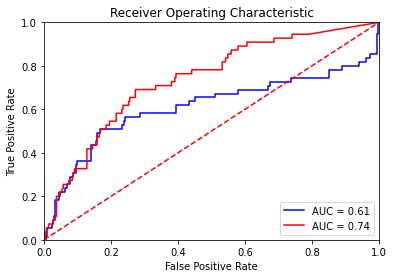

In [2]:
# Dataset 1 link: https://physionet.org/content/mimic2-iaccd/1.0/
filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = ['mort_day_censored', 'censor_flg', 'hosp_exp_flg', 'icu_exp_flg', 'stroke_flg']

model_parameters = {}

model_parameters['xgb'] = {}
model_parameters['xgb']['n_estimators'] = 151
model_parameters['xgb']['max_depth'] = 4

model_parameters['KNN'] = {}
model_parameters['KNN']['n_neighbors'] = 4

model_parameters['MLP'] = {}
model_parameters['MLP']['alpha'] = 0.01
model_parameters['MLP']['max_iter'] = 1000

model_parameters['feature_selection_level_1'] = {}
model_parameters['feature_selection_level_1']['technique'] = 'roc'

model_parameters['feature_selection_meta'] = {}
model_parameters['feature_selection_meta']['technique'] = 'roc'


X_train, X_test, y_train, y_test= prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)

stacked_model = train_stacked_model_full(model_parameters, X_train, y_train)

roc_no_shap, roc_shap, acc_no_shap, acc_shap = test_stacked_model_full(model_parameters, stacked_model, X_test, y_test)

print('ROC_NO_SHAP: ' + str(roc_no_shap))
print('ROC_SHAP: ' + str(roc_shap))

print(stacked_model['level_1_features'])
print(stacked_model['meta_features'])
print(stacked_model['meta_shap_features'])

print('ROC_NO_SHAP: ' + str(roc_no_shap))
print('ROC_SHAP: ' + str(roc_shap))

proba = stacked_model['meta'].predict_proba(X_test[stacked_model['meta_features']])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

proba = stacked_model['meta_shap'].predict_proba(X_test[stacked_model['meta_shap_features']])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.



ROC_NO_SHAP: 0.9208448117539026
ROC_SHAP: 0.9335782063054789
['hosp_exp_flg', 'icu_exp_flg', 'stroke_flg', 'resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']
['xgb_predict', 'icu_exp_flg', 'KNN_proba', 'KNN_predict', 'stroke_flg', 'resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']
['xgb_predict', 'icu_exp_flg_MLP_shap', 'hosp_exp_flg_KNN_shap', 'age_MLP_shap', 'KNN_proba', 'icu_exp_flg_KNN_shap', 'KNN_predict', 'age_KNN_shap', 'bun_first_KNN_shap', 'stroke_flg', 'sapsi_first_KNN_shap', 'age_xgb_shap', 'resp_flg', 'afib_flg', 'age', 'bun_first_MLP_shap', 'afib_flg_xgb_shap', 'bun_first', 'bun_first_xgb_shap', 'sapsi_first', 'resp_flg_KNN_shap']
ROC_NO_SHAP: 0.9208448117539026
ROC_SHAP: 0.9335782063054789


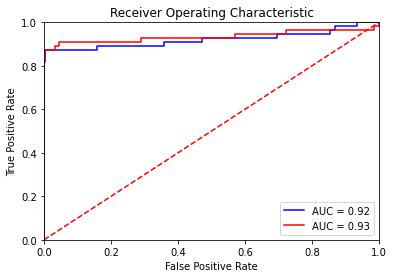

In [3]:
# Dataset 1 link: https://physionet.org/content/mimic2-iaccd/1.0/
filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = ['mort_day_censored', 'censor_flg']

model_parameters = {}

model_parameters['xgb'] = {}
model_parameters['xgb']['n_estimators'] = 151
model_parameters['xgb']['max_depth'] = 4

model_parameters['KNN'] = {}
model_parameters['KNN']['n_neighbors'] = 4

model_parameters['MLP'] = {}
model_parameters['MLP']['alpha'] = 0.01
model_parameters['MLP']['max_iter'] = 1000

model_parameters['feature_selection_level_1'] = {}
model_parameters['feature_selection_level_1']['technique'] = 'roc'

model_parameters['feature_selection_meta'] = {}
model_parameters['feature_selection_meta']['technique'] = 'roc'


X_train, X_test, y_train, y_test= prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)

stacked_model = train_stacked_model_full(model_parameters, X_train, y_train)

roc_no_shap, roc_shap, acc_no_shap, acc_shap = test_stacked_model_full(model_parameters, stacked_model, X_test, y_test)

print('ROC_NO_SHAP: ' + str(roc_no_shap))
print('ROC_SHAP: ' + str(roc_shap))

print(stacked_model['level_1_features'])
print(stacked_model['meta_features'])
print(stacked_model['meta_shap_features'])

print('ROC_NO_SHAP: ' + str(roc_no_shap))
print('ROC_SHAP: ' + str(roc_shap))

proba = stacked_model['meta'].predict_proba(X_test[stacked_model['meta_features']])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

proba = stacked_model['meta_shap'].predict_proba(X_test[stacked_model['meta_shap_features']])[:, 1]
fpr, tpr, threshold = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# FINDING BEST MODEL FOR BOTH META MODELS

In [34]:
experiment_description = ''

filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = ['mort_day_censored', 'censor_flg']

k_folds = 5

model_parameters = {}
model_parameters['xgb'] = {}
model_parameters['KNN'] = {}
model_parameters['MLP'] = {}
model_parameters['MLP']['alpha'] = 0.0001
model_parameters['MLP']['max_iter'] = 1000

model_parameters['feature_selection_level_1'] = {}
model_parameters['feature_selection_level_1']['technique'] = 'roc'

model_parameters['feature_selection_meta'] = {}
model_parameters['feature_selection_meta']['technique'] = 'roc'

# X_train, X_test, y_train, y_test = prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)

xgb_n_estimators_range = range(100, 102, 200)
xgb_max_depth_range = range(3, 4)

KNN_n_neighbors_range = range(3, 4)

MLP_alpha_range = np.logspace(-4, -2, num=1)

num_models = len(xgb_n_estimators_range)*len(xgb_max_depth_range)*len(KNN_n_neighbors_range)*len(MLP_alpha_range)

print('Number of models to be generated: ' + str(num_models))
# display(xgb_n_estimators_range, xgb_max_depth_range, KNN_n_neighbors_range, MLP_alpha_range)

df_columns = ['xgb_n_estimators', 'xgb_max_range', 'KNN_n_neighbors', 'MLP_alpha', 'level_1_feats', 'meta_feats', 'meta_feats_shap', 'roc_no_shap', 'roc_shap', 'acc_no_shap', 'acc_shap']

now = datetime.now()

output_filename = 'parameter_experiment_results/' + now.strftime("%y%m%d_%H%M%S") + '.csv'

print('Output filename: ' + output_filename)

output_df = pd.DataFrame(columns=df_columns)

with open('parameter_experiment_results/parameter_experiment_log.txt', 'a') as log_file:
    log_file.write('{:=^40}\n'.format(now.strftime("%y%m%d_%H%M%S")))
    log_file.write('Description: {}'.format(experiment_description))
    log_file.write('Output file: {}\n'.format(output_filename))
    log_file.write('Level 1 feature selection: {}\n'.format(model_parameters['feature_selection_level_1']['technique']))
    log_file.write('Meta classifier feature selection: {}\n'.format(model_parameters['feature_selection_meta']['technique']))
    log_file.write('Dropped features: {}\n'.format(features_to_drop))
    log_file.write('Number of models trained: {}\n'.format(num_models))
    log_file.write('xgb_n_estimators_range: {}\n'.format(xgb_n_estimators_range))
    log_file.write('xgb_max_depth_range: {}\n'.format(xgb_max_depth_range))
    log_file.write('KNN_n_neighbors_range: {}\n'.format(KNN_n_neighbors_range))
    log_file.write('MLP_alpha_range: {}\n'.format(MLP_alpha_range))
    log_file.write('\n\n')

with open(output_filename, "w") as csv_file:
    csv_file.write('xgb_n_estimators,xgb_max_range, KNN_n_neighbors, MLP_alpha, level_1_feats, meta_feats, meta_feats_shap, roc_no_shap, roc_shap, acc_no_shap, acc_shap\n')
    for xgb_n_estimators in xgb_n_estimators_range:
        model_parameters['xgb']['n_estimators'] = xgb_n_estimators
        for xgb_max_depth in xgb_max_depth_range:
            model_parameters['xgb']['max_depth'] = xgb_max_depth
            for KNN_n_neighbors in KNN_n_neighbors_range:
                model_parameters['KNN']['n_neighbors'] = KNN_n_neighbors
                for MLP_alpha in MLP_alpha_range:
                    for k in range(0, k_folds):
                        X_train, X_test, y_train, y_test = prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)
                        model_parameters['MLP']['alpha'] = MLP_alpha
                        stacked_model = train_stacked_model_full(model_parameters, X_train, y_train)
                        roc_no_shap, roc_shap, acc_no_shap, acc_shap = test_stacked_model_full(model_parameters, stacked_model, X_test, y_test)
                        new_row = {
                            'xgb_n_estimators': model_parameters['xgb']['n_estimators'],
                            'xgb_max_range': model_parameters['xgb']['max_depth'],
                            'KNN_n_neighbors': model_parameters['KNN']['n_neighbors'],
                            'MLP_alpha': model_parameters['MLP']['alpha'],
                            'level_1_feats': [stacked_model['level_1_features']],
                            'meta_feats': [stacked_model['meta_features']],
                            'meta_feats_shap': [stacked_model['meta_shap_features']],
                            'roc_no_shap': roc_no_shap,
                            'roc_shap': roc_shap,
                            'acc_no_shap': acc_no_shap,
                            'acc_shap': acc_shap,
                        }
                        df_row = pd.DataFrame.from_dict(new_row)
                        csv_row = df_row.to_csv(index=False, header=False)
                        csv_file.write(csv_row)
                        output_df = output_df.append(new_row, ignore_index=True)


Number of models to be generated: 1
Output filename: parameter_experiment_results/parameter_results_210922_172024.csv


Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


KeyboardInterrupt: 

In [2]:
len(range(0, 2))

2

In [47]:
new_row = {
                        'xgb_n_estimators': model_parameters['xgb']['n_estimators'],
                        'xgb_max_range': model_parameters['xgb']['max_depth'],
                        'KNN_n_neighbors': model_parameters['KNN']['n_neighbors'],
                        'MLP_alpha': model_parameters['MLP']['alpha'],
                        'level_1_feats': [stacked_model['level_1_features']],
                        'meta_feats': [stacked_model['meta_features']],
                        'meta_feats_shap': [stacked_model['meta_shap_features']],
                        'roc_no_shap': roc_no_shap,
                        'roc_shap': roc_shap,
                        'acc_no_shap': acc_no_shap,
                        'acc_shap': acc_shap,
                    }
df_row = pd.DataFrame.from_dict(new_row)
display(df_row)
df_row.to_csv(index=False, header=False)

,xgb_n_estimators,xgb_max_range,KNN_n_neighbors,MLP_alpha,level_1_feats,meta_feats,meta_feats_shap,roc_no_shap,roc_shap,acc_no_shap,acc_shap
0,100,3,3,0.0001,"[hosp_exp_flg, icu_exp_flg, stroke_flg, resp_f...","[xgb_proba, icu_exp_flg, KNN_proba, KNN_predic...","[xgb_proba, icu_exp_flg_MLP_shap, hosp_exp_flg...",0.918212,0.931068,0.977273,0.974432


'100,3,3,0.0001,"[\'hosp_exp_flg\', \'icu_exp_flg\', \'stroke_flg\', \'resp_flg\', \'afib_flg\', \'age\', \'bun_first\', \'sapsi_first\']","[\'xgb_proba\', \'icu_exp_flg\', \'KNN_proba\', \'KNN_predict\', \'stroke_flg\', \'resp_flg\', \'afib_flg\', \'age\', \'bun_first\', \'sapsi_first\']","[\'xgb_proba\', \'icu_exp_flg_MLP_shap\', \'hosp_exp_flg_KNN_shap\', \'age_MLP_shap\', \'KNN_proba\', \'KNN_predict\', \'icu_exp_flg_KNN_shap\', \'age_KNN_shap\', \'bun_first_KNN_shap\', \'sapsi_first_KNN_shap\', \'stroke_flg\', \'resp_flg\', \'age_xgb_shap\', \'afib_flg\', \'age\', \'stroke_flg_MLP_shap\', \'bun_first\', \'sapsi_first\', \'bun_first_xgb_shap\']",0.9182124273033364,0.9310682583409855,0.9772727272727273,0.9744318181818182\n'

# Evaluate Results

In [10]:
filepath = 'parameter_results_210917_213014.csv'

np.set_printoptions(threshold=np.inf)

df = pd.read_csv(filepath)

display(df.columns)

print('Average roc w/o SHAP: ', str(df[' roc_no_shap'].mean()))
print('Average roc w/ SHAP: ', str(df[' roc_shap'].mean()))


print('=================================================================')
biggest_improvement = max(df[' roc_shap'] - df[' roc_no_shap'])
print('Biggest improvement: ', str(biggest_improvement))
biggest_improvement_index = np.where((df[' roc_shap'] - df[' roc_no_shap']) == biggest_improvement)
print('Index: ' + str(biggest_improvement_index))
display('Level 1 Features: ', np.array(df[' level_1_feats'].iloc[biggest_improvement_index]))
display('Meta feats: ', np.array(df[' meta_feats'].iloc[biggest_improvement_index]))
display('Meta shap feats: ', np.array(df[' meta_feats_shap'].iloc[biggest_improvement_index]))

# print('Average improvement: ', str(stats.mean(df[' roc_shap'][df[' roc_shap'] > df[' roc_no_shap']] - df[' roc_no_shap'][df[' roc_shap'] > df[' roc_no_shap']])))

# print('Biggest impairment: ', str(max(df[' roc_no_shap'] - df[' roc_shap'])))

# print('Average impairment: ', str(stats.mean(- df[' roc_shap'][df[' roc_shap'] < df[' roc_no_shap']] + df[' roc_no_shap'][df[' roc_shap'] < df[' roc_no_shap']])))


Index(['xgb_n_estimators', ' xgb_max_range', ' KNN_n_neighbors', ' MLP_alpha',
       ' level_1_feats', ' meta_feats', ' meta_feats_shap', ' roc_no_shap',
       ' roc_shap', ' acc_no_shap', ' acc_shap'],
      dtype='object')

Average roc w/o SHAP:  0.9294408733802673
Average roc w/ SHAP:  0.9348765432098766
Biggest improvement:  0.023813896541169166
Index: (array([21]),)


'Level 1 Features: '

array(["['hosp_exp_flg', 'icu_exp_flg', 'stroke_flg', 'resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']"],
      dtype=object)

'Meta feats: '

array(["['xgb_proba', 'KNN_proba', 'icu_exp_flg', 'KNN_predict', 'stroke_flg', 'resp_flg', 'afib_flg', 'age', 'bun_first', 'sapsi_first']"],
      dtype=object)

'Meta shap feats: '

array(["['xgb_proba', 'KNN_proba', 'icu_exp_flg_MLP_shap', 'hosp_exp_flg_KNN_shap', 'age_MLP_shap', 'bun_first_KNN_shap', 'age_KNN_shap', 'KNN_predict', 'sapsi_first_KNN_shap', 'icu_exp_flg_KNN_shap', 'stroke_flg', 'stroke_flg_KNN_shap', 'resp_flg', 'age_xgb_shap', 'afib_flg', 'age', 'bun_first_MLP_shap', 'resp_flg_KNN_shap', 'bun_first', 'sapsi_first', 'bun_first_xgb_shap']"],
      dtype=object)

In [67]:
# Dataset 1 link: https://physionet.org/content/mimic2-iaccd/1.0/
filepath = 'Datasets/full_cohort_data.csv'
y_label = 'day_28_flg'
hot_encode_labels = ['day_icu_intime', 'service_unit']
features_to_drop = ['mort_day_censored', 'censor_flg', 'age', 'icu_exp_flg']

feature_selection_technique_level_1 = 'roc'

feature_selection_technique_meta = 'roc'

X_train, X_test, y_train, y_test = prepare_csv_data(filepath=filepath, y_label=y_label, hot_encode_labels=hot_encode_labels, features_to_drop=features_to_drop)

original_features = X_train.copy().columns



stacked_model = {}

stacked_model, level_1_features = train_level_1(stacked_model, X_train, y_train, feature_selection_technique_level_1)

X_train = add_shap_pred_proba_to_level_1(stacked_model, X_train, y_train, level_1_features)

stacked_model, shap_columns, meta_features, meta_shap_features = train_meta_model(stacked_model, X_train, y_train, level_1_features, feature_selection_technique_meta)

test_stacked_model(stacked_model, X_test, y_test, level_1_features, shap_columns, meta_features, meta_shap_features)

'Dropped: '

['mort_day_censored', 'censor_flg', 'age', 'icu_exp_flg']

once
once
Original # of features:  49


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


'Generated SHAP values for model type: xgb'

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Original # of features:  57


'Generated SHAP values for model type: KNN'

Using 712 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Original # of features:  65


'Generated SHAP values for model type: MLP'

'Meta features: '

['xgb_proba',
 'KNN_proba',
 'KNN_predict',
 'stroke_flg',
 'resp_flg',
 'afib_flg',
 'bun_first',
 'sapsi_first']

'Meta_shap features: '

['xgb_proba',
 'KNN_proba',
 'KNN_predict',
 'sapsi_first_KNN_shap',
 'bun_first_KNN_shap',
 'bun_first_MLP_shap',
 'sapsi_first_xgb_shap',
 'sapsi_first_MLP_shap',
 'stroke_flg',
 'afib_flg_xgb_shap',
 'stroke_flg_KNN_shap',
 'resp_flg',
 'bun_first_xgb_shap',
 'afib_flg_KNN_shap',
 'resp_flg_KNN_shap',
 'bun_first',
 'sapsi_first']

Original # of features:  49


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


'Generated SHAP values for model type: xgb'

Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Original # of features:  57


'Generated SHAP values for model type: KNN'

Using 352 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Original # of features:  65


'Generated SHAP values for model type: MLP'

# of features W/O SHAP:  8
# of features W/ SHAP:  17


'Accuracy W/O SHAP: '

0.9801136363636364

'Accuracy W/ SHAP: '

0.9801136363636364

ROC W/O SHAP:  0.9250994796449344
ROC W/ SHAP:  0.928221610039792


In [71]:
model_parameters = {}

model_parameters['xgb'] = {}
model_parameters['xgb']['n_estimators'] = 5
model_parameters['xgb']['max_depth'] = 5

model_parameters

{'xgb': {'n_estimators': 5, 'max_depth': 5}}

In [59]:
total = 0

loc = 0

proba = stacked_model['rf'].predict_proba(X_train[level_1_features])[:, 0]

explainer = shap.TreeExplainer(stacked_model['rf'])
shap_values = explainer.shap_values(X_train[level_1_features])
print(shap_values[0][loc])
print(sum(shap_values[0][loc]))


for model in stacked_model.keys() - ['meta', 'meta_shap']:
    for feat in level_1_features:
#         print(X_train[feat + '_' + model + '_shap'].iloc[loc])
        total += X_train[feat + '_' + model + '_shap'].iloc[loc]*X_train[feat].iloc[loc]
    print(model + ' | ' + str(total) + ' | ' + str(X_train[model + '_proba'].iloc[loc]))
    total = 0
    
explainer.expected_value[0] - proba[loc]

[ 0.07694517  0.01711415 -0.01179781  0.00359471  0.00716119  0.0178831 ]
0.11090051091309482
KNN | -1.075632022471912 | 0.0
MLP | -0.0747422169461331 | 0.02043877955681463
xgb | -1.0872303512878716 | 0.03975984454154968
rf | -0.27081087197128656 | 0.04724555650263552


-0.11090051091309483

# LOAD IN DATA

In [86]:
print(len(X_train.columns))
features_ini = feature_selection_fun_correlation_with_roc_sorting(X=X_train, y=y_train, correlation_treshold=0.9)
final_feat = feature_selection_fun_roc_based(X=X_train[features_ini], y=y_train, roc_treshold=0.6, pr_treshold=0.15)
print(final_feat)

print(len(X_train[original_features].columns))
features_ini = feature_selection_fun_correlation_with_roc_sorting(X=X_train.drop(columns=shap_columns), y=y_train, correlation_treshold=0.9)
final_feat = feature_selection_fun_roc_based(X=X_train[features_ini], y=y_train, roc_treshold=0.6, pr_treshold=0.15)
print(final_feat)

157
['rf_proba', 'icu_exp_flg_rf_shap', 'hospital_los_day_xgb_shap', 'icu_los_day_xgb_shap', 'bun_first_rf_shap', 'bun_first_xgb_shap', 'stroke_flg_rf_shap', 'platelet_first_xgb_shap', 'age_rf_shap', 'hospital_los_day_rf_shap', 'pco2_first_xgb_shap', 'afib_flg_rf_shap', 'platelet_first_rf_shap', 'resp_flg', 'afib_flg', 'sapsi_first_rf_shap', 'sodium_first_rf_shap', 'icu_los_day_rf_shap', 'weight_first_rf_shap', 'creatinine_first_xgb_shap', 'wbc_first_rf_shap', 'creatinine_first_rf_shap', 'potassium_first_rf_shap', 'liver_flg_rf_shap', 'age', 'hr_1st_rf_shap', 'chloride_first_rf_shap', 'resp_flg_rf_shap', 'hgb_first_rf_shap', 'iv_day_1_rf_shap', 'hour_icu_intime_rf_shap', 'mal_flg_rf_shap', 'service_num_rf_shap', 'age_xgb_shap', 'day_icu_intime_3_rf_shap', 'bmi_rf_shap', 'map_1st_rf_shap', 'abg_count_rf_shap', 'bun_first', 'sapsi_first', 'copd_flg_rf_shap', 'po2_first_rf_shap', 'temp_1st_rf_shap', 'spo2_1st_rf_shap', 'day_icu_intime_6_rf_shap']
51
['rf_proba', 'icu_exp_flg', 'stroke_flg

# TRAIN STACKED MODELS

In [21]:
if use_breast_cancer:
    breast_cancer = {}
    breast_cancer['xgb'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=10, max_depth=5).fit(breast_cancer_X_train[breast_cancer_features], breast_cancer_y_train)
    breast_cancer['rf'] = RandomForestClassifier(n_estimators=10).fit(breast_cancer_X_train[breast_cancer_features], breast_cancer_y_train)
    
    breast_cancer_X_train = breast_cancer_X_train.assign(predict_xgb=breast_cancer['xgb'].predict(breast_cancer_X_train[breast_cancer_features])).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(proba_xgb=[prob[1] for prob in breast_cancer['xgb'].predict_proba(breast_cancer_X_train[breast_cancer_features])]).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(predict_rf=breast_cancer['rf'].predict(breast_cancer_X_train[breast_cancer_features])).copy()
    breast_cancer_X_train = breast_cancer_X_train.assign(proba_rf=[prob[1] for prob in breast_cancer['rf'].predict_proba(breast_cancer_X_train[breast_cancer_features])]).copy()
    
    breast_cancer_X_test = breast_cancer_X_test.assign(predict_xgb=breast_cancer['xgb'].predict(breast_cancer_X_test[breast_cancer_features])).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(proba_xgb=[prob[1] for prob in breast_cancer['xgb'].predict_proba(breast_cancer_X_test[breast_cancer_features])]).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(predict_rf=breast_cancer['rf'].predict(breast_cancer_X_test[breast_cancer_features])).copy()
    breast_cancer_X_test = breast_cancer_X_test.assign(proba_rf=[prob[1] for prob in breast_cancer['rf'].predict_proba(breast_cancer_X_test[breast_cancer_features])]).copy()
    
#     display(breast_cancer_X_train)
    
    breast_cancer_X_train_shap = breast_cancer_X_train.copy()
    breast_cancer_X_train_shap = add_shap_to_df(model=breast_cancer['xgb'], model_type='xgb', df=breast_cancer_X_train.copy(), X_train=breast_cancer_X_train.copy(), index_shap=False, all_features=False, features=breast_cancer_features).copy()
    breast_cancer_X_train_shap = add_shap_to_df(model=breast_cancer['rf'], model_type='rf', df=breast_cancer_X_train.copy(), X_train=breast_cancer_X_train.copy(), index_shap=True, all_features=False, features=breast_cancer_features).copy()
    
    breast_cancer_X_test_shap = breast_cancer_X_test.copy()
    breast_cancer_X_test_shap = add_shap_to_df(model=breast_cancer['xgb'], model_type='xgb', df=breast_cancer_X_test.copy(), X_train=breast_cancer_X_train.copy(), index_shap=False, all_features=False, features=breast_cancer_features).copy()
    breast_cancer_X_test_shap = add_shap_to_df(model=breast_cancer['rf'], model_type='rf', df=breast_cancer_X_test.copy(), X_train=breast_cancer_X_train.copy(), index_shap=True, all_features=False, features=breast_cancer_features).copy()
    
#     display(breast_cancer_X_train_shap)
    
    breast_cancer['meta'] = LogisticRegression(max_iter=800).fit(breast_cancer_X_train, breast_cancer_y_train)
    breast_cancer['meta_shap'] = LogisticRegression(max_iter=800).fit(breast_cancer_X_train_shap, breast_cancer_y_train)
    
    display(breast_cancer['meta'].score(breast_cancer_X_test, breast_cancer_y_test))
    display(breast_cancer['meta_shap'].score(breast_cancer_X_test_shap, breast_cancer_y_test))
    
    
#     breast_cancer_meta = breast_cancer_meta.fit(breast_cancer_X_train, breast_cancer_y_train)
#     display(breast_cancer_meta.score(breast_cancer_X_test, breast_cancer_y_test))
#     breat_cancer_meta_shap

Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...
New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...
New # of features:  64
Original # of features:  34
Computing SHAP values for first layer...
Generated explainer...

New # of features:  64


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.9787234042553191

0.9787234042553191

# VALIDATE AGAINST SHAPLEY BOOSTED

In [5]:
if use_breast_cancer:
    print('No shap: ', roc_auc_score(breast_cancer_y_test, breast_cancer['meta'].predict(breast_cancer_X_test)))
    print('With shap: ', roc_auc_score(breast_cancer_y_test, breast_cancer['meta_shap'].predict(breast_cancer_X_test_shap)))

No shap:  0.9925373134328358
With shap:  0.9925373134328358


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


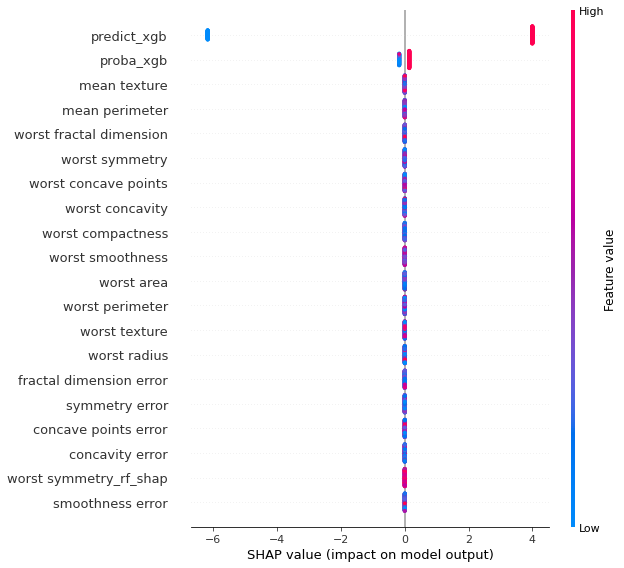

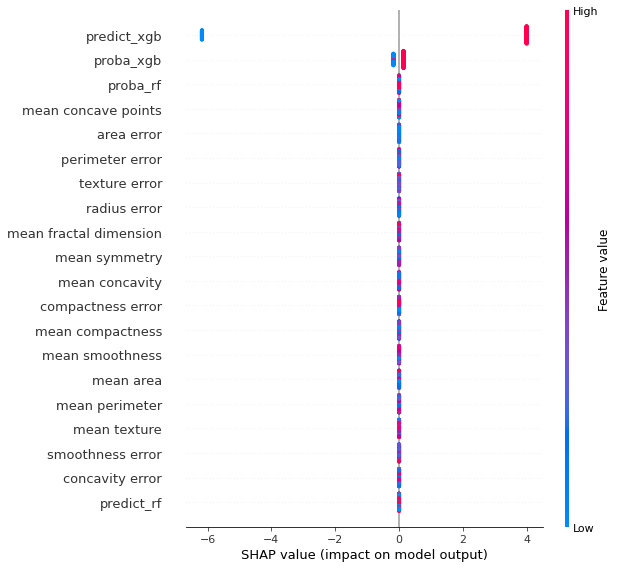

In [16]:
explainer = shap.TreeExplainer(breast_cancer['meta_shap'])
shap_values = explainer.shap_values(breast_cancer_X_test_shap)
shap.summary_plot(shap_values, breast_cancer_X_test_shap)

explainer = shap.TreeExplainer(breast_cancer['meta'])
shap_values = explainer.shap_values(breast_cancer_X_test)
shap.summary_plot(shap_values, breast_cancer_X_test)